# Install Packages

codes stolen from:
https://github.com/myc159/Deep-Taylor-Decomposition

In [ ]:
!git clone https://github.com/myc159/Deep-Taylor-Decomposition

Cloning into 'Deep-Taylor-Decomposition'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 101 (delta 26), reused 82 (delta 15), pack-reused 0
Receiving objects: 100% (101/101), 1.79 MiB | 3.11 MiB/s, done.
Resolving deltas: 100% (26/26), done.


In [ ]:
pwd

'/content'

In [ ]:
cd Deep-Taylor-Decomposition/

/content/Deep-Taylor-Decomposition


# Load Packages

In [ ]:
import argparse
import logging
import logging.handlers
import os
import pdb
import random
from PIL import Image

import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision
from torchvision.utils import save_image
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from model import *
from model import saliency_mapping as sa_map
from torch.autograd import Variable

In [ ]:
import json
import pandas as pd
import math
from tqdm import tqdm 
import cv2
import numpy as np
import os

import torch 
import torchvision
import torch.nn as nn 
from IPython.display import Image 
from torchvision import transforms
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 12345
random.seed(seed)
torch.manual_seed(seed)
import PIL
import requests
  
from sklearn import decomposition    
from sklearn.preprocessing import MinMaxScaler

from PIL import Image

# Load data and get cropped bbox

In [ ]:
def get_synthetic_instances_ann():
    coco_dir = "/content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/synthetic/instances_test_role.json"
    images_dir = "/content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/synthetic/test/images/"
    test_json_dir = coco_dir
    with open(test_json_dir) as json_file:
        test_coco = json.load(json_file)
    img_list = pd.DataFrame(test_coco['images'])
    annotations = pd.DataFrame(test_coco['annotations'])
    ann = annotations.merge(img_list, how='left', left_on="image_id", right_on="id")
    return ann


def crop_image(file_name, bbox):
    dir = "/content/drive/MyDrive/111 Rendered.ai/RarePlanes/datasets/synthetic/test/images/"
    ori_img_dir = dir+file_name
    my_image = cv2.imread(ori_img_dir)
    buffer=0
    cropped_im = my_image[math.floor(bbox[1]) - buffer : math.floor(bbox[1]) + math.ceil(bbox[3]) + buffer,
                          math.floor(bbox[0]) - buffer : math.floor(bbox[0]) + math.ceil(bbox[2]) + buffer,:]
    return cropped_im


def upsampling(crop_im, max_shape):
    crop_im = crop_im.view(1,crop_im.shape[0],crop_im.shape[1],crop_im.shape[2]).permute(0,3,1,2)
    # print(crop_im.shape)
    upsampler = nn.Upsample(size=(max_shape[0], max_shape[1]), mode="nearest")
    upsampled_crop_im = upsampler(crop_im)
    # print(upsampled_crop_im.shape)
    return upsampled_crop_im

In [ ]:
# load instance annotations
ann = get_synthetic_instances_ann()
# save all bbox
n_instances = 5
for i in tqdm(range(n_instances)):
    instance = ann.iloc[i]
    file_name = instance['file_name']
    bbox = instance['bbox']
    cropped_im = crop_image(file_name, bbox)
    # save cropped images
    save_dir = "/content/sample_data/cropped_img_dir/plane/" # change into your directory!!!!

    im = Image.fromarray(cropped_im)
    im.save(save_dir+str(i)+"_"+str(file_name)[:-4]+".png")

For DTD, we don't have to do upsampling!

# DTD

In [ ]:
test_dir = "/content/sample_data/cropped_img_dir/" 
batch_size = 1 
num_workers = 1
model = "resnet18" 
sample_dir = "/content/sample_data/"
heatmap_scale = 5000

In [ ]:
def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


In [ ]:
# import torch
# from torchvision import datasets, transforms as T

# transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()])
# dataset = datasets.ImageNet(".", split="train", transform=transform)

# means = []
# stds = []
# for img in subset(dataset):
#     means.append(torch.mean(img))
#     stds.append(torch.std(img))

# mean = torch.mean(torch.tensor(means))
# std = torch.mean(torch.tensor(stds))

In [ ]:
logger = logging.getLogger()
logger.setLevel("DEBUG")
formatter = logging.Formatter(
    '%(asctime)s [%(levelname)s] %(message)s (%(filename)s:%(lineno)s)')
stream_handler = logging.StreamHandler()
stream_handler.setLevel("INFO")
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)
logging.info('data loading')

test_dataset = datasets.ImageFolder(
    test_dir,
    transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]))
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                          num_workers=num_workers, pin_memory=True, shuffle=False,
                          drop_last=False)


2020-12-01 04:27:13,045 [INFO] data loading (<ipython-input-173-94f0a51499ec>:9)
2020-12-01 04:27:13,045 [INFO] data loading (<ipython-input-173-94f0a51499ec>:9)
2020-12-01 04:27:13,045 [INFO] data loading (<ipython-input-173-94f0a51499ec>:9)
2020-12-01 04:27:13,045 [INFO] data loading (<ipython-input-173-94f0a51499ec>:9)
2020-12-01 04:27:13,045 [INFO] data loading (<ipython-input-173-94f0a51499ec>:9)
2020-12-01 04:27:13,045 [INFO] data loading (<ipython-input-173-94f0a51499ec>:9)


In [ ]:
logging.info('prepare model')

model = resnet50(pretrained=True)

2020-12-01 04:27:15,107 [INFO] prepare model (<ipython-input-174-578786cd68d0>:1)
2020-12-01 04:27:15,107 [INFO] prepare model (<ipython-input-174-578786cd68d0>:1)
2020-12-01 04:27:15,107 [INFO] prepare model (<ipython-input-174-578786cd68d0>:1)
2020-12-01 04:27:15,107 [INFO] prepare model (<ipython-input-174-578786cd68d0>:1)
2020-12-01 04:27:15,107 [INFO] prepare model (<ipython-input-174-578786cd68d0>:1)
2020-12-01 04:27:15,107 [INFO] prepare model (<ipython-input-174-578786cd68d0>:1)


In [ ]:
# load faster_rcnn 
faster_rcnn = torch.load("/content/drive/My Drive/111 Rendered.ai/rareplane_models/model_0043999.pth")

In [ ]:
def matching_fpn2res(faster_rnn, res50):
    fas2res = {"res2":"layer1", "res3":"layer2", "res4":"layer3", "res5":"layer4"}
    frcnn_dict = defaultdict(list)
    res50_dict = defaultdict(list)

    for fas_layer_i in fas2res:
        for k in faster_rnn["model"]:
          if fas_layer_i in k and "weight" in k and "shortcut" not in k:
            frcnn_dict[fas_layer_i].append(k)
        for k in res50.keys():
          res_layer_i = fas2res[fas_layer_i]
          if "weight" in k and res_layer_i in k and "down" not in k:
            res50_dict[res_layer_i].append(k)

    return frcnn_dict, res50_dict


def flatten_dict(dic):
    lst = []
    for k,v in dic.items():
        lst+=v
    return lst


def fpn2res_mapping(fas_lst, res50_lst):
    map = {}
    for i,k in enumerate(res50_lst):
        map[fas_lst[i]] = k
    return map

In [ ]:
# make model pth mapping
frcnn_dict, res50_dict = matching_fpn2res(faster_rcnn, res50)
fas_lst = flatten_dict(frcnn_dict)
res50_lst = flatten_dict(res50_dict)
mapping = fpn2res_mapping(fas_lst, res50_lst)

In [ ]:
res50_by_fpn = res50
for k in mapping:
    res50_by_fpn[mapping[k]] = faster_rnn["model"][k]

In [ ]:
model.load_state_dict(res50_by_fpn)

<All keys matched successfully>

In [ ]:

# if args.model.startswith('vgg'):
#     model_archi = 'vgg'
#     if args.model.endswith('11'):
#         model = vgg11(pretrained=True)
#     elif args.model.endswith('11_bn'):
#         model = vgg11_bn(pretrained=True)
#     elif args.model.endswith('13'):
#         model = vgg13(pretrained=True)
#     elif args.model.endswith('13_bn'):
#         model = vgg13_bn(pretrained=True)
#     elif args.model.endswith('16'):
#         model = vgg16(pretrained=True)
#     elif args.model.endswith('16_bn'):
#         model = vgg16_bn(pretrained=True)
#     elif args.model.endswith('19'):
#         model = vgg19(pretrained=True)
#     elif args.model.endswith('19_bn'):
#         model = vgg19_bn(pretrained=True)
# elif args.model.startswith('resnet'):
#     model_archi = 'resnet'
#     if args.model.endswith('18'):
#         model = resnet18(pretrained=True)
#     elif args.model.endswith('34'):
#         model = resnet34(pretrained=True)
#     elif args.model.endswith('50'):
#         model = resnet50(pretrained=True)
#     elif args.model.endswith('101'):
#         model = resnet101(pretrained=True)
#     elif args.model.endswith('152'):
#         model = resnet152(pretrained=True)
# else:
#     raise ValueError(f"{args.model} is not available")

model.train(False)
module_list = sa_map.model_flattening(model)
act_store_model = sa_map.ActivationStoringNet(module_list)
DTD = sa_map.DTD()
loss_func = nn.CrossEntropyLoss()

logging.info('testing with saliency mapping start')

test_top1 = 0
test_top5 = 0
test_count = 0
with torch.no_grad():
    for i, (image, target) in enumerate(test_loader):
        image = Variable(image)
        target = Variable(target)

        module_stack, output = act_store_model(image)
        loss = loss_func(output, target)
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        test_count += image.size(0)
        test_top1 += acc1[0] * image.size(0)
        test_top1_avg = test_top1 / test_count
        test_top5 += acc5[0] * image.size(0)
        test_top5_avg = test_top5 / test_count

        if i % 20 == 0:
            logging.info('sample saliency map generation')
            saliency_map = DTD(module_stack, output, 1000, "resnet")
            saliency_map = torch.sum(saliency_map, dim=1)
            saliency_map_sample = saliency_map[0].detach().numpy()
            saliency_map_sample = np.maximum(0, saliency_map_sample)*255*heatmap_scale
            saliency_map_sample = np.minimum(255, saliency_map_sample)
            saliency_map_sample = np.uint8(saliency_map_sample)
            saliency_heatmap = cv2.applyColorMap(saliency_map_sample, cv2.COLORMAP_BONE)
            if not os.path.exists(sample_dir):
                os.mkdir(sample_dir)
            heatmap_name = f"{i}th_sample.png"
            cv2.imwrite(os.path.join(sample_dir, heatmap_name), saliency_heatmap)
            sample_origin = image.cpu().data[0]
            origin_name = f"{i}th_origin.png"
            save_image(sample_origin, os.path.join(sample_dir, origin_name))

        logging.info((f"Test, step #{i}/{len(test_loader)},, "
                      f"top1 accuracy {test_top1_avg:.3f}, "
                      f"top5 accuracy {test_top5_avg:.3f}, "
                      f"loss {torch.mean(loss):.3f}, "))

log = '\n'.join([
    f'ImageNet pretrained {model} Saliency Mapping',
    f'# Test Result',
    f'- top1 acc: {test_top1_avg:.4f}',
    f'- top5 acc: {test_top5_avg:.4f}'])

logging.info('test finish')
logging.info(log)

2020-12-01 04:27:24,901 [INFO] testing with saliency mapping start (<ipython-input-179-7de9944091bd>:41)
2020-12-01 04:27:24,901 [INFO] testing with saliency mapping start (<ipython-input-179-7de9944091bd>:41)
2020-12-01 04:27:24,901 [INFO] testing with saliency mapping start (<ipython-input-179-7de9944091bd>:41)
2020-12-01 04:27:24,901 [INFO] testing with saliency mapping start (<ipython-input-179-7de9944091bd>:41)
2020-12-01 04:27:24,901 [INFO] testing with saliency mapping start (<ipython-input-179-7de9944091bd>:41)
2020-12-01 04:27:24,901 [INFO] testing with saliency mapping start (<ipython-input-179-7de9944091bd>:41)
2020-12-01 04:27:25,198 [INFO] sample saliency map generation (<ipython-input-179-7de9944091bd>:61)
2020-12-01 04:27:25,198 [INFO] sample saliency map generation (<ipython-input-179-7de9944091bd>:61)
2020-12-01 04:27:25,198 [INFO] sample saliency map generation (<ipython-input-179-7de9944091bd>:61)
2020-12-01 04:27:25,198 [INFO] sample saliency map generation (<ipytho

# Saliency Map by DTD

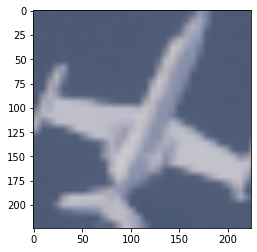

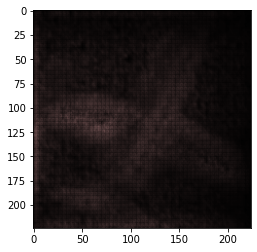

In [ ]:
sample_output = cv2.imread("/content/sample_data/0th_sample.png") # change this into your output dir 
im = cv2.imread("/content/sample_data/0th_origin.png")
plt.imshow(im);plt.show()
plt.imshow(sample_output)